## This notebook trains and test the XGBoost Model.

In [1]:
%autosave 60

Autosaving every 60 seconds


In [1]:
# defining os variables
BUCKET_NAME = "msil_raw"
FOLDER_NAME = "training_data"
TRAINFILE = "trainset_final.csv"
VALIDFILE = "validset_final.csv"
TESTFILE = "testset_final.csv"

In [2]:
# importing the variables
import google.datalab.storage as storage
import pandas as pd
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time
from datetime import datetime
from scipy import integrate
import pickle

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# setting up the parameters
plt.rcParams["figure.figsize"] = (10, 10)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("precision", 15)
sns.set_style("darkgrid")

In [5]:
# importing the training data. If using local system, skip this cell and use os library instead.
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + TRAINFILE)

uri = data_csv.uri
%gcs read --object $uri --variable data

trainset = pd.read_csv(BytesIO(data))
trainset.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,tp,sp,EVVSP,EVVSP_delta,EVVSP_change,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVACO_Z,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVVAC_delta,EVVAC_change,EVODO,EVODOH,Driver name,EVSMA_in,EVSMA_EWMA,EVSMA_delta
0,1,2018,11,17,8,39,18,0,0.0,0.0,0.0,0.0,0,19.0,16,17,-7.0,213,16,20.0,21.5,0.0,0.0,0.0,688,0.0,1,93.0,93.0,0.0
1,1,2018,11,17,8,39,19,0,1000.0,0.0,0.0,0.0,0,19.0,16,17,-5.0,213,16,20.0,21.5,0.0,0.0,0.0,688,0.0,1,93.0,93.0,0.0
2,1,2018,11,17,8,39,20,0,2000.0,0.0,0.0,0.0,0,19.0,16,17,-8.0,213,16,20.0,21.5,0.0,0.0,0.0,688,0.0,1,93.0,93.0,0.0
3,1,2018,11,17,8,39,21,0,3000.0,0.0,0.0,0.0,0,19.0,16,17,-9.0,213,16,20.0,21.5,0.0,0.0,0.0,688,0.0,1,93.0,93.0,0.0
4,1,2018,11,17,8,39,22,0,4000.0,0.0,0.0,0.0,0,19.0,16,17,-4.0,213,16,20.0,21.5,0.0,0.0,0.0,688,0.0,1,93.0,93.0,0.0


In [6]:
# importing the validset
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + VALIDFILE)

uri = data_csv.uri
%gcs read --object $uri --variable data

validset = pd.read_csv(BytesIO(data))
validset.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,tp,sp,EVVSP,EVVSP_delta,EVVSP_change,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVACO_Z,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVVAC_delta,EVVAC_change,EVODO,EVODOH,Driver name,EVSMA_in,EVSMA_EWMA,EVSMA_delta
0,6,2018,12,3,7,21,41,1678,0.0,0.0,0.0,0.0,0,10.5,12,12,39.0,-39,12,14.0,15.0,0.0,0.0,0.0,1666,0.0,20,72.700000000000003,72.700000000000003,0.0
1,6,2018,12,3,7,21,42,1678,1000.0,0.0,0.0,0.0,0,10.5,12,12,39.0,-39,12,14.0,15.0,0.0,0.0,0.0,1666,0.0,20,72.700000000000003,72.700000000000003,0.0
2,6,2018,12,3,7,21,43,1678,2000.0,0.0,0.0,0.0,0,10.5,12,12,40.0,-39,12,14.0,15.0,0.0,0.0,0.0,1666,0.0,20,72.700000000000003,72.700000000000003,0.0
3,6,2018,12,3,7,21,44,1678,3000.0,0.0,0.0,0.0,0,10.5,12,12,39.0,-39,12,14.0,15.0,0.0,0.0,0.0,1666,0.0,20,72.700000000000003,72.700000000000003,0.0
4,6,2018,12,3,7,21,45,1678,4000.0,0.0,0.0,0.0,0,10.5,12,12,32.0,-39,12,14.0,15.0,0.0,0.0,0.0,1666,0.0,20,72.700000000000003,72.700000000000003,0.0


In [4]:
# importing the testset
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + TESTFILE)

uri = data_csv.uri
%gcs read --object $uri --variable data

testset = pd.read_csv(BytesIO(data))
testset.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,tp,sp,EVVSP,EVVSP_delta,EVVSP_change,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVACO_Z,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVVAC_delta,EVVAC_change,EVODO,EVODOH,Driver name,EVSMA_in,EVSMA_EWMA,EVSMA_delta
0,7,2018,11,26,18,53,20,1744,0.0,0.0,0.0,0.0,0,21.5,29,34,100.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
1,7,2018,11,26,18,53,21,1744,1000.0,0.0,0.0,0.0,0,21.5,29,34,95.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
2,7,2018,11,26,18,53,22,1744,2000.0,0.0,0.0,0.0,0,21.5,29,34,92.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
3,7,2018,11,26,18,53,23,1744,3000.0,0.0,0.0,0.0,0,21.5,29,34,103.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
4,7,2018,11,26,18,53,24,1744,4000.0,0.0,0.0,0.0,0,21.5,29,34,96.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0


In [8]:
len(trainset)

3871645

### Info Table regarding Dataset division

|  Data   | Range of Trips |Number of Observations|
|---------|----------------|----------------------|
|Trainset |    0 - 1643    |    3871645           |
|Validset |  1643 - 1743   |    224878            |
|Testset  |  1743 - 2218   |    667516            |

In [83]:
trainset = trainset.drop(columns = ["tp", "EVSMA_EWMA"])
validset = validset.drop(columns = ["tp", "EVSMA_EWMA"])
testset = testset.drop(columns = ["tp", "EVSMA_EWMA"])

In [84]:
# dropping the target variables from our dataset
x_trainset = trainset.drop(columns = ["EVSMA_delta"])
y_trainset = trainset["EVSMA_delta"]

x_validset = validset.drop(columns = ["EVSMA_delta"])
y_validset = validset["EVSMA_delta"]

x_testset = testset.drop(columns = ["EVSMA_delta"])
y_testset = testset["EVSMA_delta"]

In [85]:
# defining the model parameters
params = {
    "eta":0.01,
    "n_estimators": 100,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 1,
    "gamma": 0,
    "eval_metric": "rmse",
    "nthreads": 4,
    "objective": "reg:linear"   
}

In [86]:
# converting the datasets into DMatrix, a format required by XGBoost
dtrainset = xgb.DMatrix(x_trainset, label = y_trainset)
dvalidset = xgb.DMatrix(x_validset, label = y_validset)

In [87]:
# training the Model
model_train = xgb.train(params, dtrainset, 5000, evals = [(dvalidset, "valid_set")], verbose_eval=1000)

[0]	valid_set-rmse:0.489532
[1000]	valid_set-rmse:0.004783
[2000]	valid_set-rmse:0.004584
[3000]	valid_set-rmse:0.004457
[4000]	valid_set-rmse:0.004364


In [88]:
# saving the trained model
pickle.dump(model_train, open("model_xgb_stack_final.pickle.dat", "wb"))

In [5]:
# loading the saved model
model_train = pickle.load(open('model_xgb_stack_final.pickle.dat','rb'))

In [90]:
# converting the testset into DMatrix
dtest = xgb.DMatrix(x_testset)

In [91]:
# Predictions
y_pred = model_train.predict(dtest)

In [92]:
# making a dataframe of actual and predicted values
result_df = pd.DataFrame({
    "y": y_testset,
    "yhat": y_pred
})

In [93]:
# calculating the Root Mean Square Error
err = (((result_df["y"] - result_df["yhat"])**2).mean())**0.5
print("RMSE = {:.4f}".format(err))

# calculating the Mean Average Precision Error
#mape = ((result_df["y"] - result_df["yhat"])/result_df["y"]).mean()
#print("MAPE = {:.4f}".format(mape))

RMSE = 0.0056


---
## Testing Model on different trips

In [6]:
# importing the testset
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + TESTFILE)

uri = data_csv.uri
%gcs read --object $uri --variable data

testset = pd.read_csv(BytesIO(data))
testset.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,tp,sp,EVVSP,EVVSP_delta,EVVSP_change,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVACO_Z,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVVAC_delta,EVVAC_change,EVODO,EVODOH,Driver name,EVSMA_in,EVSMA_EWMA,EVSMA_delta
0,7,2018,11,26,18,53,20,1744,0.0,0.0,0.0,0.0,0,21.5,29,34,100.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
1,7,2018,11,26,18,53,21,1744,1000.0,0.0,0.0,0.0,0,21.5,29,34,95.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
2,7,2018,11,26,18,53,22,1744,2000.0,0.0,0.0,0.0,0,21.5,29,34,92.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
3,7,2018,11,26,18,53,23,1744,3000.0,0.0,0.0,0.0,0,21.5,29,34,103.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0
4,7,2018,11,26,18,53,24,1744,4000.0,0.0,0.0,0.0,0,21.5,29,34,96.0,213,34,22.5,23.0,0.0,0.0,0.0,1110,0.0,23,82.299999999999997,82.299999999999997,0.0


In [97]:
# extracting few trips
test_trip_1814 = testset[testset["tp"] == 1814]
test_trip_1936 = testset[testset["tp"] == 1936]
test_trip_1973 = testset[testset["tp"] == 1973]
test_trip_1757 = testset[testset["tp"] == 1757]
test_trip_1937 = testset[testset["tp"] == 1937]
test_trip_1889 = testset[testset["tp"] == 1889]
test_trip_2018 = testset[testset["tp"] == 2018]
test_trip_2011 = testset[testset["tp"] == 2011]
test_trip_1947 = testset[testset["tp"] == 1947]
test_trip_1860 = testset[testset["tp"] == 1860]

In [171]:
tpno = 1756
test_trip = testset[testset["tp"] == tpno]

In [172]:
dist = testset[testset["tp"] == tpno]["EVODOH"].iloc[-1]

In [173]:
sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]
print("SMA Absolute = {}".format(sma_absolute))

sma_actual = test_trip["EVSMA_EWMA"]

test_trip = test_trip.drop(columns = ["EVSMA_EWMA", "tp"])

x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
y_test_trip = test_trip["EVSMA_delta"]

SMA Absolute = 90.5


In [174]:
#model_train = pickle.load(open('xgb_finale.dat','rb'))

In [175]:
d_test_trip = xgb.DMatrix(x_test_trip)

In [176]:
predictions = model_train.predict(d_test_trip)

In [177]:
for i in range(0, len(predictions)):
  if predictions[i]<0:
    predictions[i]=0

In [178]:
# making a dataframe of actual and predicted values
test_trip_df = pd.DataFrame({
    "y": y_test_trip,
    "yhat": predictions
})

In [179]:
sma_list = []
for i in range(0, len(predictions)):
  temp_sma = sma_absolute - predictions[i]
  sma_list.append(temp_sma)
  sma_absolute = temp_sma

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


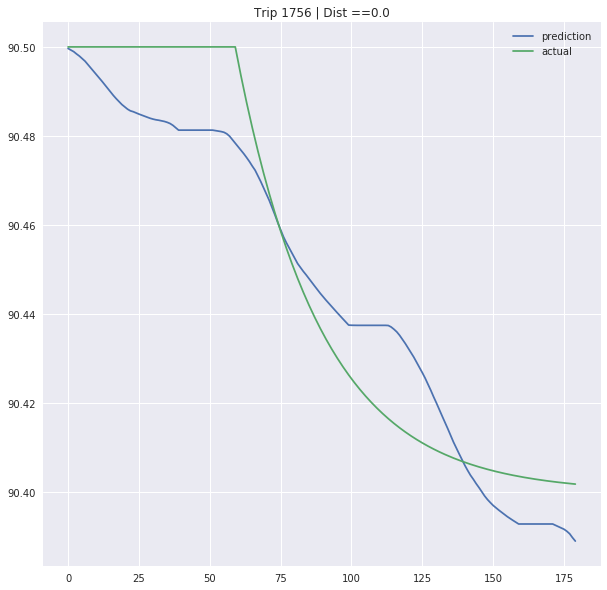

In [180]:
title = "Trip " + str(tpno) + " | Dist ==" + str(round(dist, 2)) 
plt.plot(sma_list, label = "prediction")
plt.plot(list(sma_actual), label = "actual")
plt.title(title)
plt.legend()
plt.show()

In [181]:
err = (((sma_list[-1] - list(sma_actual)[-1])))/(list(sma_actual)[0] - list(sma_actual)[-1])
print("Error for the Trip = {:.2f} %".format(err * 100))

Error for the Trip = -13.04 %


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CommandException: No URLs matched: plot_name
XGB1744.png
------------------------------
CommandException: No URLs matched: plot_name
XGB1745.png
------------------------------


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars


CommandException: No URLs matched: plot_name
XGB1746.png
------------------------------
CommandException: No URLs matched: plot_name
XGB1747.png
------------------------------
CommandException: No URLs matched: plot_name
XGB1748.png
------------------------------
CommandException: No URLs matched: plot_name
XGB1749.png
------------------------------


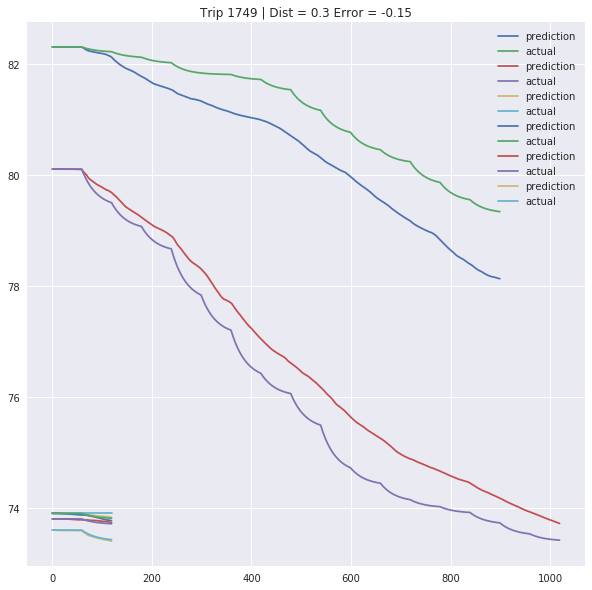

In [189]:
for i in range(1744,1750):
  test_trip = testset[testset["tp"] == i]
  dist = testset[testset["tp"] == i]["EVODOH"].iloc[-1]
  sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]

  sma_actual = test_trip["EVSMA_EWMA"]

  test_trip = test_trip.drop(columns = ["EVSMA_EWMA", "tp"])

  x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
  y_test_trip = test_trip["EVSMA_delta"]
  d_test_trip = xgb.DMatrix(x_test_trip)
  predictions = model_train.predict(d_test_trip)
  for k in range(0, len(predictions)):
    if predictions[k]<0:
      predictions[k]=0
      
  # making a dataframe of actual and predicted values
  test_trip_df = pd.DataFrame({
    "y": y_test_trip,
    "yhat": predictions
  })
  
  sma_list = []
  for j in range(0, len(predictions)):
    temp_sma = sma_absolute - predictions[j]
    sma_list.append(temp_sma)
    sma_absolute = temp_sma
  
  err = (((sma_list[-1] - list(sma_actual)[-1])))/(list(sma_actual)[0] - list(sma_actual)[-1])
  title = "Trip "+str(i)+" | Dist = "+str(round(dist, 2))+" Error = "+str(round(err, 2))
  plot_name = "XGB" + str(i) +".png"
  plt.plot(sma_list, label = "prediction")
  plt.plot(list(sma_actual), label = "actual")
  plt.title(title)
  plt.legend()
  plt.savefig(plot_name)
  print(plot_name)
  print("------------------------------")

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


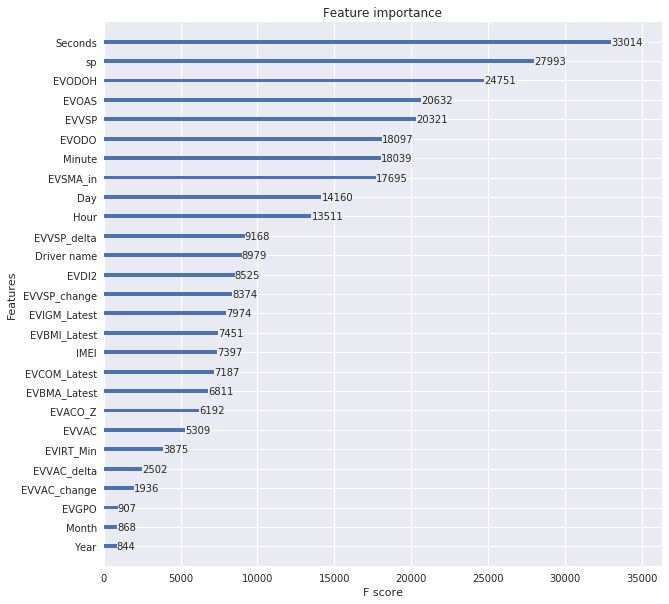

In [107]:
xgb.plot_importance(model_train)

---
## Creating the Stacked DataSet

In [115]:
test_trip = trainset[trainset["tp"] == 0]

In [116]:
sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]
print("SMA Absolute = {}".format(sma_absolute))

sma_actual = test_trip["EVSMA_EWMA"]

test_trip = test_trip.drop(columns = ["EVSMA_EWMA", "tp"])

x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
y_test_trip = test_trip["EVSMA_delta"]

SMA Absolute = 93.0


In [117]:
d_test_trip = xgb.DMatrix(x_test_trip)

In [118]:
predictions = model_train.predict(d_test_trip)

In [119]:
for i in range(0, len(predictions)):
  if predictions[i]<0:
    predictions[i]=0

In [120]:
sma_list = []
for i in range(0, len(predictions)):
  temp_sma = sma_absolute - predictions[i]
  sma_list.append(temp_sma)
  sma_absolute = temp_sma

In [121]:
# making a dataframe of actual and predicted values
test_trip_df = pd.DataFrame({
    "y": sma_actual,
    "yhat": sma_list
})

In [122]:
test_trip_df.head()

,y,yhat
0,93.0,92.999488800764084
1,93.0,92.998987704515457
2,93.0,92.998491972684860
3,93.0,92.997980743646622
4,93.0,92.997486114501953


In [124]:
# calculating the Root Mean Square Error
err = (((test_trip_df["y"] - test_trip_df["yhat"])**2).mean())**0.5
print("RMSE = {:.4f}".format(err))

# calculating the Mean Average Precision Error
mape = ((test_trip_df["y"] - test_trip_df["yhat"])/test_trip_df["y"]).mean()
print("MAPE = {:.4f} %".format(mape*100))

RMSE = 0.5058
MAPE = -0.5136 %


In [125]:
len(test_trip_df)

900

In [126]:
test_trip_df.to_csv('stack_xgb_data.csv', index = False)
!gsutil cp 'stack_xgb_data.csv' 'gs://msil_raw/training_data/stack_xgb_data.csv'
%gcs read --object gs://msil_raw/training_data/stack_xgb_data.csv --variable stack_xgb_data
df2 = pd.read_csv(BytesIO(stack_xgb_data))

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
/ [1 files][ 30.6 KiB/ 30.6 KiB]                                                
Operation completed over 1 objects/30.6 KiB.                                     


In [129]:
#################################
test_trip = trainset[trainset["tp"] == 1]

In [130]:
sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]
print("SMA Absolute = {}".format(sma_absolute))

sma_actual = test_trip["EVSMA_EWMA"]

test_trip = test_trip.drop(columns = ["EVSMA_EWMA", "tp"])

x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
y_test_trip = test_trip["EVSMA_delta"]

SMA Absolute = 89.5


In [131]:
d_test_trip = xgb.DMatrix(x_test_trip)

In [132]:
predictions = model_train.predict(d_test_trip)

In [133]:
for i in range(0, len(predictions)):
  if predictions[i]<0:
    predictions[i]=0

In [134]:
for i in range(0, len(predictions)):
  if predictions[i]<0:
    predictions[i]=0

In [135]:
sma_list = []
for i in range(0, len(predictions)):
  temp_sma = sma_absolute - predictions[i]
  sma_list.append(temp_sma)
  sma_absolute = temp_sma

In [136]:
test_trip_df = pd.DataFrame({
    "y": sma_actual,
    "yhat": sma_list
})

In [137]:
test_trip_df.head()

,y,yhat
900,89.500000000000000,89.499990969896317
901,89.499999999999986,89.499773472547531
902,89.499999999999957,89.499527126550674
903,89.499999999999957,89.499197125434875
904,89.499999999999943,89.498830825090408


In [139]:
# calculating the Root Mean Square Error
err = (((test_trip_df["y"] - test_trip_df["yhat"])**2).mean())**0.5
print("RMSE = {:.4f}".format(err))

# calculating the Mean Average Precision Error
mape = ((test_trip_df["y"] - test_trip_df["yhat"])/test_trip_df["y"]).mean()
print("MAPE = {:.4f} %".format(mape*100))

RMSE = 0.2033
MAPE = -0.0710 %


In [140]:
len(test_trip_df)

2280

In [141]:
mybucket = storage.Bucket('msil_raw')
data_csv = mybucket.object('training_data/stack_xgb_data.csv')

uri = data_csv.uri
%gcs read --object $uri --variable daaa

stacked_df = pd.read_csv(BytesIO(daaa))
stacked_df.head()

,y,yhat
0,93.0,92.999488800764084
1,93.0,92.998987704515457
2,93.0,92.998491972684860
3,93.0,92.997980743646622
4,93.0,92.997486114501953


In [142]:
len(stacked_df)

900

In [143]:
test_trip_df = pd.concat((stacked_df, test_trip_df), axis = 0).reset_index(drop = True)

In [144]:
len(test_trip_df)

3180

In [145]:
test_trip_df.to_csv('stack_xgb_data.csv', index = False)
!gsutil cp 'stack_xgb_data.csv' 'gs://msil_raw/training_data/stack_xgb_data.csv'
%gcs read --object gs://msil_raw/training_data/stack_xgb_data.csv --variable stack_xgb_data
df2 = pd.read_csv(BytesIO(stack_xgb_data))

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
- [1 files][109.9 KiB/109.9 KiB]                                                
Operation completed over 1 objects/109.9 KiB.                                    


### Looping through all other trips

In [ ]:
for i in range(756, 1643):
  print("------------------------------")
  test_trip = trainset[trainset["tp"] == i]
  print("Trip Number = {}".format(i))
  sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]
  print("SMA Absolute = {}".format(sma_absolute))

  sma_actual = test_trip["EVSMA_EWMA"]

  test_trip = test_trip.drop(columns = ["EVSMA_EWMA", "tp"])

  x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
  y_test_trip = test_trip["EVSMA_delta"]
    
  d_test_trip = xgb.DMatrix(x_test_trip)
  predictions = model_train.predict(d_test_trip)
  
  for i in range(0, len(predictions)):
    if predictions[i]<0:
      predictions[i]=0
    
  sma_list = []
  for i in range(0, len(predictions)):
    temp_sma = sma_absolute - predictions[i]
    sma_list.append(temp_sma)
    sma_absolute = temp_sma
    
  test_trip_df = pd.DataFrame({
    "y": sma_actual,
    "yhat": sma_list
  })
  
  # calculating the Root Mean Square Error
  err = (((test_trip_df["y"] - test_trip_df["yhat"])**2).mean())**0.5
  print("RMSE = {:.4f}".format(err))
 
  # calculating the Mean Average Precision Error
  mape = ((test_trip_df["y"] - test_trip_df["yhat"])/test_trip_df["y"]).mean()
  print("MAPE = {:.4f}".format(mape))
    
  mybucket = storage.Bucket('msil_raw')
  data_csv = mybucket.object('training_data/stack_xgb_data.csv')

  uri = data_csv.uri
  %gcs read --object $uri --variable daaa

  stacked_df = pd.read_csv(BytesIO(daaa))
  stacked_df.head()
  print("Trip length = {}".format(len(test_trip_df)))
  print("Data length prior = {}".format(len(stacked_df)))
  test_trip_df = pd.concat((stacked_df, test_trip_df), axis = 0).reset_index(drop = True)
  print("Data length after = {}".format(len(test_trip_df)))
    
  test_trip_df.to_csv('stack_xgb_data.csv', index = False)
  
  !gsutil cp 'stack_xgb_data.csv' 'gs://msil_raw/training_data/stack_xgb_data.csv'
  %gcs read --object gs://msil_raw/training_data/stack_xgb_data.csv --variable stack_xgb_data
  df2 = pd.read_csv(BytesIO(stack_xgb_data))

------------------------------
Trip Number = 756
SMA Absolute = 43.0
RMSE = 0.0015
MAPE = 0.0000
Trip length = 60
Data length prior = 1730324
Data length after = 1730384
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 58.6 MiB/ 58.6 MiB]                                                
Operation completed over 1 objects/58.6 MiB.                                     
------------------------------
Trip Number = 757
SMA Absolute = 75.0
RMSE = 0.1939
MAPE = -0.0016
Trip length = 3480
Data length prior = 1730384
Data length after = 1733864
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 58.8 MiB/ 58.8 MiB]                                                
Operation completed over 1 objects/58.8 MiB.                                     
------------------------------
Trip Number = 758
SMA Absolute = 50.8
RMSE = 0.3628
MAPE = -0.0055
Trip length = 2700
Data length prior = 1733864
Data length after = 1736564
Copying file://stack_xgb_data.csv [C

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 61.5 MiB/ 61.5 MiB]                                                
Operation completed over 1 objects/61.5 MiB.                                     
------------------------------
Trip Number = 798
SMA Absolute = 36.3
RMSE = 0.1483
MAPE = -0.0033
Trip length = 780
Data length prior = 1816004
Data length after = 1816784
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 61.5 MiB/ 61.5 MiB]                                                
Operation completed over 1 objects/61.5 MiB.                                     
------------------------------
Trip Number = 799
SMA Absolute = 35.3
RMSE = 0.0198
MAPE = 0.0003
Trip length = 300
Data length prior = 1816784
Data length after = 1817084
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 61.5 MiB/ 61.5 MiB]                                                
Operation completed over 1 objects/61.5 MiB.                       

RMSE = 1.2156
MAPE = 0.0140
Trip length = 4920
Data length prior = 1834844
Data length after = 1839764
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 62.3 MiB/ 62.3 MiB]                                                
Operation completed over 1 objects/62.3 MiB.                                     
------------------------------
Trip Number = 819
SMA Absolute = 60.6
RMSE = 0.9660
MAPE = 0.0183
Trip length = 2520
Data length prior = 1839764
Data length after = 1842284
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 62.4 MiB/ 62.4 MiB]                                                
Operation completed over 1 objects/62.4 MiB.                                     
------------------------------
Trip Number = 820
SMA Absolute = 38.2
RMSE = 0.1460
MAPE = 0.0031
Trip length = 660
Data length prior = 1842284
Data length after = 1842944
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 62.4 MiB/ 62.4 MiB]             

------------------------------
Trip Number = 839
SMA Absolute = 36.3
RMSE = 0.3976
MAPE = -0.0110
Trip length = 1860
Data length prior = 1876964
Data length after = 1878824
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 63.6 MiB/ 63.6 MiB]                                                
Operation completed over 1 objects/63.6 MiB.                                     
------------------------------
Trip Number = 840
SMA Absolute = 74.6
RMSE = 0.3115
MAPE = 0.0035
Trip length = 300
Data length prior = 1878824
Data length after = 1879124
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 63.7 MiB/ 63.7 MiB]                                                
Operation completed over 1 objects/63.7 MiB.                                     
------------------------------
Trip Number = 841
SMA Absolute = 73.7
RMSE = 0.2474
MAPE = -0.0032
Trip length = 600
Data length prior = 1879124
Data length after = 1879724
Copying file://stack_xgb_data.csv [C

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 66.4 MiB/ 66.4 MiB]                                                
Operation completed over 1 objects/66.4 MiB.                                     
------------------------------
Trip Number = 881
SMA Absolute = 15.5
RMSE = 0.2451
MAPE = 0.0125
Trip length = 420
Data length prior = 1958743
Data length after = 1959163
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 66.4 MiB/ 66.4 MiB]                                                
Operation completed over 1 objects/66.4 MiB.                                     
------------------------------
Trip Number = 882
SMA Absolute = 59.7
RMSE = 0.0029
MAPE = 0.0000
Trip length = 60
Data length prior = 1959163
Data length after = 1959223
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 66.4 MiB/ 66.4 MiB]                                                
Operation completed over 1 objects/66.4 MiB.                         

Trip length = 60
Data length prior = 1991033
Data length after = 1991093
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 67.5 MiB/ 67.5 MiB]                                                
Operation completed over 1 objects/67.5 MiB.                                     
------------------------------
Trip Number = 902
SMA Absolute = 89.7
RMSE = 1.6865
MAPE = -0.0443
Trip length = 7800
Data length prior = 1991093
Data length after = 1998893
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 67.7 MiB/ 67.7 MiB]                                                
Operation completed over 1 objects/67.7 MiB.                                     
------------------------------
Trip Number = 903
SMA Absolute = 18.1
RMSE = 0.0102
MAPE = 0.0005
Trip length = 60
Data length prior = 1998893
Data length after = 1998953
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 67.7 MiB/ 67.7 MiB]                                           

------------------------------
Trip Number = 922
SMA Absolute = 90.9
RMSE = 1.6231
MAPE = -0.0277
Trip length = 7080
Data length prior = 2053973
Data length after = 2061053
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 69.9 MiB/ 69.9 MiB]                                                
Operation completed over 1 objects/69.9 MiB.                                     
------------------------------
Trip Number = 923
SMA Absolute = 93.1
RMSE = 1.2355
MAPE = 0.0142
Trip length = 5160
Data length prior = 2061053
Data length after = 2066213
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 70.0 MiB/ 70.0 MiB]                                                
Operation completed over 1 objects/70.0 MiB.                                     
------------------------------
Trip Number = 924
SMA Absolute = 54.8
RMSE = 0.4692
MAPE = 0.0077
Trip length = 1920
Data length prior = 2066213
Data length after = 2068133
Copying file://stack_xgb_data.csv [

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 73.5 MiB/ 73.5 MiB]                                                
Operation completed over 1 objects/73.5 MiB.                                     
------------------------------
Trip Number = 964
SMA Absolute = 93.0
RMSE = 0.7979
MAPE = -0.0134
Trip length = 7500
Data length prior = 2168333
Data length after = 2175833
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
/ [1 files][ 73.8 MiB/ 73.8 MiB]                                                
Operation completed over 1 objects/73.8 MiB.                                     
------------------------------
Trip Number = 965
SMA Absolute = 84.7
RMSE = 1.8143
MAPE = 0.0362
Trip length = 7260
Data length prior = 2175833
Data length after = 2183093
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 74.0 MiB/ 74.0 MiB]                                                
Operation completed over 1 objects/74.0 MiB.                     

Trip length = 60
Data length prior = 2254073
Data length after = 2254133
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 76.5 MiB/ 76.5 MiB]                                                
Operation completed over 1 objects/76.5 MiB.                                     
------------------------------
Trip Number = 985
SMA Absolute = 76.3
RMSE = 0.1364
MAPE = -0.0011
Trip length = 180
Data length prior = 2254133
Data length after = 2254313
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 76.5 MiB/ 76.5 MiB]                                                
Operation completed over 1 objects/76.5 MiB.                                     
------------------------------
Trip Number = 986
SMA Absolute = 88.7
RMSE = 0.8796
MAPE = -0.0003
Trip length = 7500
Data length prior = 2254313
Data length after = 2261813
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 76.7 MiB/ 76.7 MiB]                                         

------------------------------
Trip Number = 1005
SMA Absolute = 87.7
RMSE = 0.7956
MAPE = -0.0005
Trip length = 5760
Data length prior = 2335733
Data length after = 2341493
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 79.4 MiB/ 79.4 MiB]                                                
Operation completed over 1 objects/79.4 MiB.                                     
------------------------------
Trip Number = 1006
SMA Absolute = 46.4
RMSE = 0.2622
MAPE = -0.0044
Trip length = 1860
Data length prior = 2341493
Data length after = 2343353
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 79.5 MiB/ 79.5 MiB]                                                
Operation completed over 1 objects/79.5 MiB.                                     
------------------------------
Trip Number = 1007
SMA Absolute = 93.8
RMSE = 0.3299
MAPE = 0.0028
Trip length = 360
Data length prior = 2343353
Data length after = 2343713
Copying file://stack_xgb_data.cs

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 82.2 MiB/ 82.2 MiB]                                                
Operation completed over 1 objects/82.2 MiB.                                     
------------------------------
Trip Number = 1047
SMA Absolute = 40.6
RMSE = 0.4161
MAPE = 0.0089
Trip length = 600
Data length prior = 2424087
Data length after = 2424687
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 82.2 MiB/ 82.2 MiB]                                                
Operation completed over 1 objects/82.2 MiB.                                     
------------------------------
Trip Number = 1048
SMA Absolute = 39.9
RMSE = 0.0000
MAPE = 0.0000
Trip length = 60
Data length prior = 2424687
Data length after = 2424747
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 82.2 MiB/ 82.2 MiB]                                                
Operation completed over 1 objects/82.2 MiB.                       

Trip length = 840
Data length prior = 2477966
Data length after = 2478806
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 84.0 MiB/ 84.0 MiB]                                                
Operation completed over 1 objects/84.0 MiB.                                     
------------------------------
Trip Number = 1068
SMA Absolute = 42.1
RMSE = 0.0231
MAPE = -0.0004
Trip length = 120
Data length prior = 2478806
Data length after = 2478926
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 84.0 MiB/ 84.0 MiB]                                                
Operation completed over 1 objects/84.0 MiB.                                     
------------------------------
Trip Number = 1069
SMA Absolute = 46.0
RMSE = 0.3237
MAPE = 0.0058
Trip length = 1020
Data length prior = 2478926
Data length after = 2479946
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 84.1 MiB/ 84.1 MiB]                                       

------------------------------
Trip Number = 1088
SMA Absolute = 92.1
RMSE = 0.5517
MAPE = 0.0063
Trip length = 8760
Data length prior = 2523625
Data length after = 2532385
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 85.8 MiB/ 85.8 MiB]                                                
Operation completed over 1 objects/85.8 MiB.                                     
------------------------------
Trip Number = 1089
SMA Absolute = 90.6
RMSE = 0.6928
MAPE = -0.0099
Trip length = 4680
Data length prior = 2532385
Data length after = 2537065
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 86.0 MiB/ 86.0 MiB]                                                
Operation completed over 1 objects/86.0 MiB.                                     
------------------------------
Trip Number = 1090
SMA Absolute = 91.0
RMSE = 0.2675
MAPE = 0.0027
Trip length = 540
Data length prior = 2537065
Data length after = 2537605
Copying file://stack_xgb_data.csv

Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 88.8 MiB/ 88.8 MiB]                                                
Operation completed over 1 objects/88.8 MiB.                                     
------------------------------
Trip Number = 1130
SMA Absolute = 72.7
RMSE = 0.1324
MAPE = -0.0013
Trip length = 180
Data length prior = 2620883
Data length after = 2621063
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 88.8 MiB/ 88.8 MiB]                                                
Operation completed over 1 objects/88.8 MiB.                                     
------------------------------
Trip Number = 1131
SMA Absolute = 70.9
RMSE = 0.9880
MAPE = -0.0150
Trip length = 3120
Data length prior = 2621063
Data length after = 2624183
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 88.9 MiB/ 88.9 MiB]                                                
Operation completed over 1 objects/88.9 MiB.                   

Trip length = 60
Data length prior = 2657027
Data length after = 2657087
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
/ [1 files][ 90.1 MiB/ 90.1 MiB]                                                
Operation completed over 1 objects/90.1 MiB.                                     
------------------------------
Trip Number = 1151
SMA Absolute = 91.9
RMSE = 0.0036
MAPE = 0.0000
Trip length = 60
Data length prior = 2657087
Data length after = 2657147
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 90.1 MiB/ 90.1 MiB]                                                
Operation completed over 1 objects/90.1 MiB.                                     
------------------------------
Trip Number = 1152
SMA Absolute = 91.9
RMSE = 0.0092
MAPE = 0.0001
Trip length = 60
Data length prior = 2657147
Data length after = 2657207
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 90.1 MiB/ 90.1 MiB]                                            

------------------------------
Trip Number = 1171
SMA Absolute = 41.7
RMSE = 0.1296
MAPE = -0.0028
Trip length = 480
Data length prior = 2685636
Data length after = 2686116
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
------------------------------
Trip Number = 1172
SMA Absolute = 89.5
RMSE = 0.0025
MAPE = 0.0000
Trip length = 60
Data length prior = 2686116
Data length after = 2686176
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
------------------------------
Trip Number = 1173
SMA Absolute = 90.7
RMSE = 0.3010
MAPE = 0.0012
Trip length = 2880
Data length prior = 2686176
Data length after = 2689056
Copying file://stack_xgb_data.csv [

Trip length = 7799
Data length prior = 2788851
Data length after = 2796650
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 94.8 MiB/ 94.8 MiB]                                                
Operation completed over 1 objects/94.8 MiB.                                     
------------------------------
Trip Number = 1213
SMA Absolute = 49.6
RMSE = 0.0936
MAPE = 0.0013
Trip length = 180
Data length prior = 2796650
Data length after = 2796830
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
\ [1 files][ 94.8 MiB/ 94.8 MiB]                                                
Operation completed over 1 objects/94.8 MiB.                                     
------------------------------
Trip Number = 1214
SMA Absolute = 89.5
RMSE = 0.3921
MAPE = 0.0030
Trip length = 2700
Data length prior = 2796830
Data length after = 2799530
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 94.9 MiB/ 94.9 MiB]                                       

------------------------------
Trip Number = 1233
SMA Absolute = 68.0
RMSE = 0.6283
MAPE = 0.0058
Trip length = 2760
Data length prior = 2851366
Data length after = 2854126
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 96.7 MiB/ 96.7 MiB]                                                
Operation completed over 1 objects/96.7 MiB.                                     
------------------------------
Trip Number = 1234
SMA Absolute = 52.8
RMSE = 0.2219
MAPE = 0.0033
Trip length = 240
Data length prior = 2854126
Data length after = 2854366
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][ 96.7 MiB/ 96.7 MiB]                                                
Operation completed over 1 objects/96.7 MiB.                                     
------------------------------
Trip Number = 1235
SMA Absolute = 52.5
RMSE = 0.0282
MAPE = 0.0004
Trip length = 120
Data length prior = 2854366
Data length after = 2854486
Copying file://stack_xgb_data.csv [

Trip length = 60
Data length prior = 2973989
Data length after = 2974049
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][100.8 MiB/100.8 MiB]                                                
Operation completed over 1 objects/100.8 MiB.                                    
------------------------------
Trip Number = 1275
SMA Absolute = 92.4
RMSE = 1.7178
MAPE = 0.0177
Trip length = 2580
Data length prior = 2974049
Data length after = 2976629
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][100.9 MiB/100.9 MiB]                                                
Operation completed over 1 objects/100.9 MiB.                                    
------------------------------
Trip Number = 1276
SMA Absolute = 81.3
RMSE = 0.1043
MAPE = 0.0008
Trip length = 180
Data length prior = 2976629
Data length after = 2976809
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][100.9 MiB/100.9 MiB]                                         

------------------------------
Trip Number = 1295
SMA Absolute = 63.3
RMSE = 0.0667
MAPE = 0.0008
Trip length = 240
Data length prior = 3024794
Data length after = 3025034
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][102.5 MiB/102.5 MiB]                                                
Operation completed over 1 objects/102.5 MiB.                                    
------------------------------
Trip Number = 1296
SMA Absolute = 91.4
RMSE = 0.1630
MAPE = -0.0001
Trip length = 3060
Data length prior = 3025034
Data length after = 3028094
Copying file://stack_xgb_data.csv [Content-Type=text/csv]...
| [1 files][102.6 MiB/102.6 MiB]                                                
Operation completed over 1 objects/102.6 MiB.                                    
------------------------------
Trip Number = 1297
SMA Absolute = 81.4
RMSE = 1.2655
MAPE = 0.0153
Trip length = 4260
Data length prior = 3028094
Data length after = 3032354
Copying file://stack_xgb_data.csv

In [192]:
path_fig='gs://msil_raw/test_figures/'+plot_name
!gsutil cp plot_name path_fig


CommandException: No URLs matched: plot_name


In [191]:
path_fig

'gs://msil_raw/test_figures/XGB1749.png'